# Cell types Optimisation Exercise


**We are pleased to invite you to take part in an exciting challenge**

** In order to do that, you will modify:**
1. The **features** you want to optimize for.
2. The **parameters** of the model.
3. The **settings** of the optimisation (number of generations / individuals).


These are the rules and guidelines:
1. You **can change the features** you want to optimize for, we will provide a list of the allowed ones.
2. You are allowed to **change the model parameters**. You can use the number of fixed parameters that you want.
3. You are encouraged to report any problems in the **[chat channel](https://gitter.im/BlueBrain/SimulationTutorials)** dedicated to this tutorial and also to discuss possible ways to solve the problem.   
4. **Copy and paste the output** of the **last two cells** of this notebook in a **private chat** with [Elisabetta](https://gitter.im/elisabettai).
5. Hint: **we will score** your model based on how much it **generalizes**.
6. **Have fun** and win some **amazing prizes**.____________

Authors of this script:

Werner Van Geit @ Blue Brain Project

Elisabetta Iavarone @ Blue Brain Project

___
### Overview:

* In this exercise we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/) and to constrain the model parameters.
____

You can run this tutorial on your computer, for installation instruction, look [here](https://github.com/BlueBrain/SimulationTutorials/tree/master/General/Installation)
___

<IPython.core.display.Javascript object>


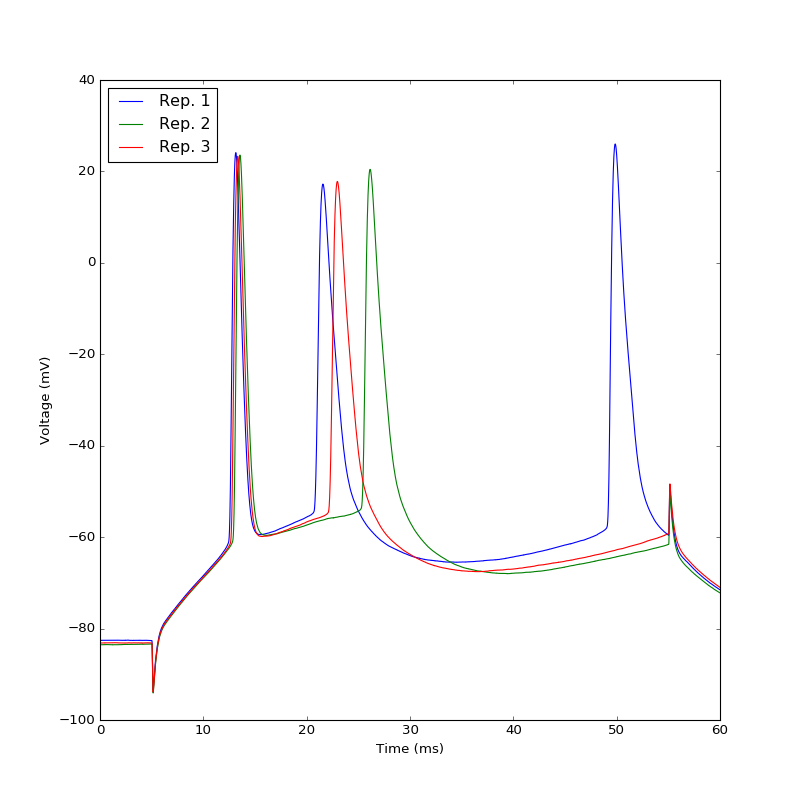

In [1]:
%load_ext autoreload
%autoreload

import numpy
import json
import IPython
from json2html import *

import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 10

import collections

import efel
import neurom

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

# Define the directory containing the voltage traces
data_dir = 'data/'

# Store data in a dictionary step_name : [list of repetitions]
#steps_dict = collections.OrderedDict(sorted({'StepNeg':23,'StepPos':36}.items(), key = lambda x:x[0]))
steps_dict = collections.OrderedDict({'ShortStepPos': []})

# Import the os Python module to interact with the operating system
import os
from glob import glob

files_list = glob(data_dir + "*.txt")

for file_name in files_list:
    if "APWaveform" in file_name:
        data = numpy.loadtxt(file_name)
        # Correct for liquid junction potential
        data[:, 1] -= 14.0
        steps_dict['ShortStepPos'].append(data)

    
        
fig1, axes = plt.subplots(len(steps_dict), sharey = True)
axes = [axes]
for idx, step_name in enumerate(steps_dict.keys()):
    for rep, trace in enumerate(steps_dict[step_name]):
        axes[idx].plot(trace[:,0],trace[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Voltage (mV)')
        axes[idx].set_xlabel('Time (ms)')
        axes[idx].legend(loc = 'best')
        #axes[idx].set_xlim([0,3])

# 2. Electrophysiological features


In [2]:
feature_names = ['time_to_first_spike', 'AP_width']
#feature_names = ['time_to_first_spike', 'AHP_depth', 'AP_width', 'AP_height', 'Spikecount', 'AP1_width', 'AP2_width']

# Extract features
import efel

# Define stimulus start and end times
steps_info = {'LongStepNeg': [20, 1020], 'ShortStepPos': [5, 55], 'LongStepPos': [700, 2700]}

# Prepare the traces for eFEL
def get_features(data):
    # All the traces converted in eFEL format
    efel_traces = {'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:
            # A single eFEL trace 
            trace = {}
            trace['T'] = rep[:,0]
            trace['V'] = rep[:,1]
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], feature_names)
                                                               
    
    mean_std_features = collections.defaultdict(lambda:collections.defaultdict(dict))
    for step_name in features_values:
        for efeature in features_values[step_name][0]:
            efeature_values = [x[efeature] for x in features_values[step_name]]
            mean_std_features[step_name][efeature] = {'mean': numpy.mean(efeature_values), 
                                                      'std': numpy.std(efeature_values)}
    
    return mean_std_features

mean_std_features = get_features(steps_dict)
IPython.display.HTML(json2html.convert(json=dict(mean_std_features)))

# 3. Model definition


In [3]:
morphology_file = 'simple.swc'
morphology = ephys.morphologies.NrnFileMorphology(morphology_file)

somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')

hh_mech = ephys.mechanisms.NrnMODMechanism(                                         
        name='hh',                                                                  
        suffix='hh',                                                                
        locations=[somatic_loc])   
gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',                                                           
        param_name='gnabar_hh',                                                     
        locations=[somatic_loc],                                                    
        bounds=[0.0, 1.0],
        frozen=False)                                                            
gkbar_param = ephys.parameters.NrnSectionParameter(                              
        name='gkbar_hh',                                                         
        param_name='gkbar_hh',                                                   
        bounds=[0.01, 1],
        locations=[somatic_loc],                                                 
        frozen=False) 
gl_param = ephys.parameters.NrnSectionParameter(                                    
        name='gl_hh',                                                           
        param_name='gl_hh',                                                     
        locations=[somatic_loc],                                                    
        value=1e-4,
        frozen=True)  
el_param = ephys.parameters.NrnSectionParameter(                                    
        name='el_hh',                                                           
        param_name='el_hh',                                                     
        locations=[somatic_loc],                                                    
        value=-82,
        frozen=True)
cm_param = ephys.parameters.NrnSectionParameter(                                 
        name='cm',                                                               
        param_name='cm',                                                         
        value=1.0,                                                               
        locations=[somatic_loc],                                                 
        frozen=True)   
celsius_param = ephys.parameters.NrnGlobalParameter(                                 
        name='celsius',                                                               
        param_name='celsius',                                                         
        value=34.0,                                                                 
        frozen=True)   
vinit_param = ephys.parameters.NrnGlobalParameter(                                 
        name='v_init',                                                               
        param_name='v_init',                                                         
        value=-82,                                                                 
        frozen=True)   
simple_cell = ephys.models.CellModel(                                            
        name='simple_cell',                                                      
        morph=morphology,                                                             
        mechs=[hh_mech],                                                         
        params=[cm_param, gnabar_param, gkbar_param, gl_param, el_param, celsius_param, vinit_param])   
print simple_cell

simple_cell:
  morphology:
    simple.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    cm: ['somatic'] cm = 1.0
    gnabar_hh: ['somatic'] gnabar_hh = [0.0, 1.0]
    gkbar_hh: ['somatic'] gkbar_hh = [0.01, 1]
    gl_hh: ['somatic'] gl_hh = 0.0001
    el_hh: ['somatic'] el_hh = -82
    celsius: celsius = 34.0
    v_init: v_init = -82



In [4]:
soma_loc = ephys.locations.NrnSeclistCompLocation(                               
        name='soma',                                                             
        seclist_name='somatic',                                                  
        sec_index=0,                                                             
        comp_x=0.5)         

# 4. Setting-up a simulation


In [5]:
nrn = ephys.simulators.NrnSimulator()                                            

# IDREST = .93 nA
# IV = -0.4 nA
# APWaveform = 1.05 nA

sweep_protocols = []                                                             
for protocol_name, amplitude in [('step1', 1.05)]:         
    stim = ephys.stimuli.NrnSquarePulse(                                         
                step_amplitude=amplitude,                                        
                step_delay=5,                                                  
                step_duration=55,                                                
                location=soma_loc,                                               
                total_duration=60)                                              
    rec = ephys.recordings.CompRecording(                                        
            name='%s.soma.v' % protocol_name,                                    
            location=soma_loc,                                                   
            variable='v')                                                        
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])       
    sweep_protocols.append(protocol)                                             
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

default_params = {'gnabar_hh': 0.3, 'gkbar_hh': 0.02}
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)


<IPython.core.display.Javascript object>


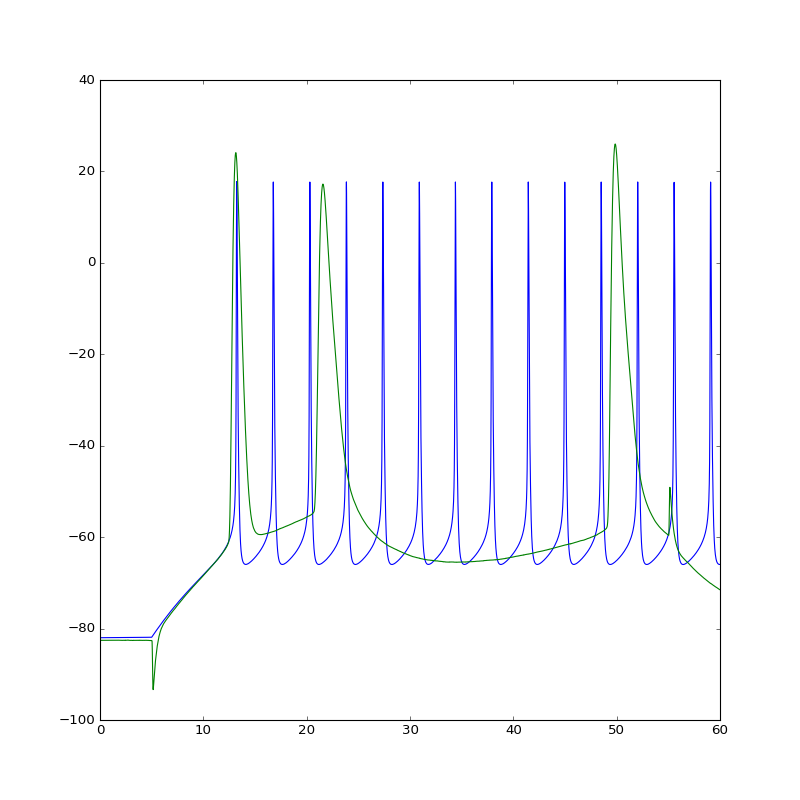

In [6]:

def plot_responses(responses):
    fig1, ax = plt.subplots(len(responses))
    ax.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1.soma.v')
    ax.plot(steps_dict['ShortStepPos'][0][:, 0], steps_dict['ShortStepPos'][0][:, 1])
plot_responses(responses)


In [7]:

efel_feature_means = {'step1': {feature_name: mean_std_features['ShortStepPos'][feature_name] 
                                for feature_name in feature_names}}
                                                                                 
objectives = []                                                                  
                                                                                 
for protocol in sweep_protocols:                                                 
    stim_start = protocol.stimuli[0].step_delay                                  
    stim_end = stim_start + protocol.stimuli[0].step_duration                    
    for efel_feature_name, mean_std_dict in efel_feature_means[protocol.name].iteritems():
        mean = mean_std_dict['mean']
        std = mean_std_dict['std']
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)              
        feature = ephys.efeatures.eFELFeature(                                   
                    feature_name,                                                
                    efel_feature_name=efel_feature_name,                         
                    recording_names={'': '%s.soma.v' % protocol.name},           
                    stim_start=stim_start,                                       
                    stim_end=stim_end,                                           
                    exp_mean=mean,                                               
                    exp_std=std)                                        
        objective = ephys.objectives.SingletonObjective(                         
            feature_name,                                                        
            feature)                                                             
        objectives.append(objective)         
        
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives)        

cell_evaluator = ephys.evaluators.CellEvaluator(                                 
        cell_model=simple_cell,                                                  
        param_names=['gnabar_hh', 'gkbar_hh'],                                   
        fitness_protocols={twostep_protocol.name: twostep_protocol},             
        fitness_calculator=score_calc,                                           
        sim=nrn)        

print cell_evaluator.evaluate_with_dicts(default_params)                         


{'step1.time_to_first_spike': 0.6123724356957945, 'step1.AP_width': 20.655676935044873}


# 5. Parameters optimization 

In [8]:
optimisation = bpopt.optimisations.DEAPOptimisation(                              
        evaluator=cell_evaluator,                                                
        offspring_size = 10)    

Run the optimisation:

In [9]:
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=10)               


In [18]:
print 'Final population: ', final_pop                                            
best_ind = hall_of_fame[0]                                                       
print 'Best individual: ', best_ind                                              
print 'Fitness values: ', best_ind.fitness.values             

best_ind_dict = cell_evaluator.param_dict(best_ind)                              
print cell_evaluator.evaluate_with_dicts(best_ind_dict)                 

Final population:  [[0.7305810753471247, 0.06135213993117018], [0.7321736656416212, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.06183445636482386], [0.7310554373880654, 0.02522354384109362], [0.7305810753471247, 0.03281400670137178], [0.8130305636789752, 0.06135213993117018], [0.8130305636789752, 0.06135213993117018], [0.7287911739524846, 0.05377764956343503], [0.5661183294452795, 0.06183445636482386], [0.48903900417775725, 0.06183445636482386], [0.7310554373880654, 0.08855815073725265]]
Best individual:  [0.7321736656416212, 0.06183445636482386]
Fitness values:  (21.036426740299156, 5.5113519212621505)
{

Plot the evolution of the features:

<IPython.core.display.Javascript object>


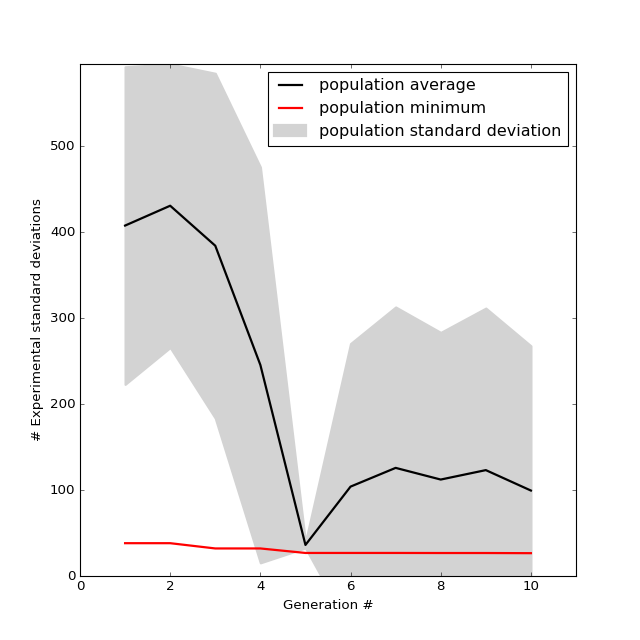

In [11]:
gen_numbers = logs.select('gen')
min_fitness = numpy.array(logs.select('min'))
max_fitness = logs.select('max')
mean_fitness = numpy.array(logs.select('avg'))
std_fitness = numpy.array(logs.select('std'))

fig, ax = plt.subplots(1, figsize=(8, 8), facecolor='white')

std = std_fitness
mean = mean_fitness
minimum = min_fitness
stdminus = mean - std                                                           
stdplus = mean + std

ax.plot(                                                                      
    gen_numbers,                                                                
    mean,                                                                       
    color='black',                                                              
    linewidth=2,                                                                
    label='population average')                                                 

ax.fill_between(                                                              
    gen_numbers,                                                                
    stdminus,                                                                   
    stdplus,                                                                    
    color='lightgray',                                                          
    linewidth=2,                                                                
    label=r'population standard deviation')                                     

ax.plot(                                                                      
    gen_numbers,                                                                
    minimum,                                                                    
    color='red',                                                                
    linewidth=2,                                                                
    label='population minimum')                                                 

ax.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)                       
ax.set_xlabel('Generation #')                                                 
ax.set_ylabel('# Experimental standard deviations')                                            
ax.set_ylim([0, max(stdplus)])                                                
ax.legend() 

Plotting the voltage responses:

<IPython.core.display.Javascript object>


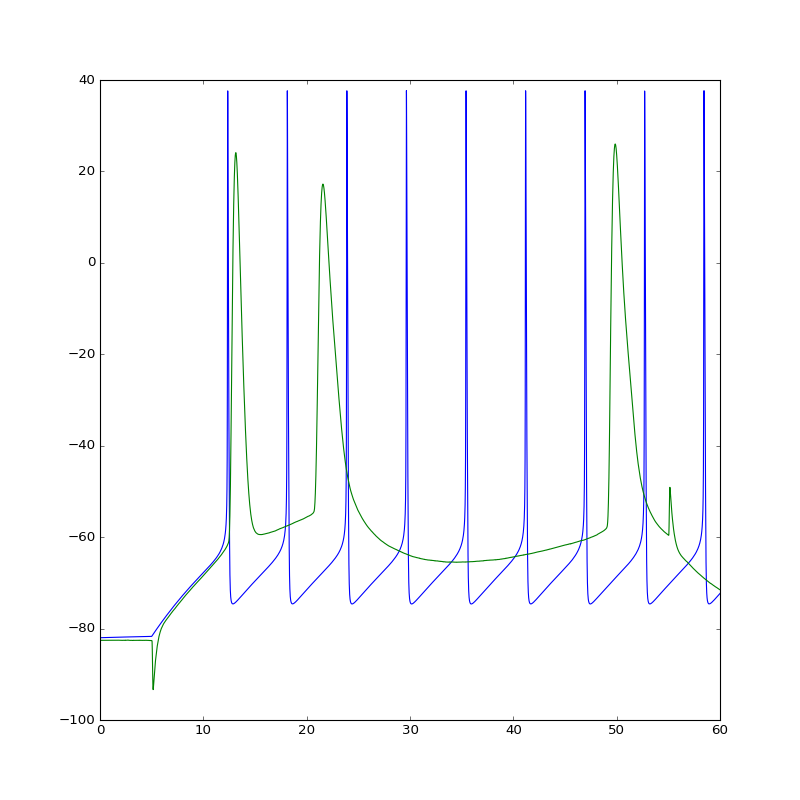

{'step1.time_to_first_spike': 5.5113519212621505, 'step1.AP_width': 21.036426740299156}


In [19]:
responses = twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn)
plot_responses(responses)


Once you are happy with your result, **send** the output of the **two cells below** to **[Elisabetta](https://gitter.im/elisabettai)**.

In [21]:
best_params = {}
for name in best_ind_dict:
    best_params[name] = best_ind_dict[name]
frozen_pars = [param.name for param in simple_cell.params.values() if param.frozen]
for name in frozen_pars:
    best_params[name] = simple_cell.params[name].value

pprint.pprint(best_params)

{'celsius': 34.0,
 'cm': 1.0,
 'el_hh': -82,
 'gkbar_hh': 0.06183445636482386,
 'gl_hh': 0.0001,
 'gnabar_hh': 0.7321736656416212,
 'v_init': -82}


In [22]:
pprint.pprint(cell_evaluator.evaluate_with_dicts(best_ind_dict))

{'step1.AP_width': 21.036426740299156,
 'step1.time_to_first_spike': 5.5113519212621505}
